In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyldavis

     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 45.7 MB/s 
     |████████████████████████████████| 15.7 MB 195 kB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=db971e722d31c1b7b4cf147323f3b7ba9d6f95548ea5f9a55434a6d25c066500
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing NLP plugins
#Spacy Imports
import spacy
from spacy.lang.en import English
nlp_spacy = English()

#NLTK Imports
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

#Gensim Imports
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel as lda_gensim
from gensim.models import CoherenceModel

import pprint

import pyLDAvis
import pyLDAvis.gensim_models
# Initiate pyLDAvis to load in Jupyter Cell
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
df=pd.read_csv("/content/drive/MyDrive/cleaned_data.csv")
df = df.drop('Unnamed: 0', axis = 1)
print(df)

                                                  Title  ...        Source
0     Michigan wants to lead U.S. in electric vehicl...  ...      Bridgemi
1     Republicans’ hold on Lansing power could grow ...  ...      Bridgemi
2     Dueling gatherings highlight split as Michigan...  ...      Bridgemi
3     Michigan counties dump mask rules for thousand...  ...      Bridgemi
4     Gov. Gretchen Whitmer signs $70B Michigan budg...  ...      Bridgemi
...                                                 ...  ...           ...
1727  The Climate Conversations - S2: The green cons...  ...  Channel News
1728  Heart of the Matter - S2: What are the challen...  ...  Channel News
1729  The Climate Conversations - S2: Can our homes ...  ...  Channel News
1730  Heart of the Matter - S2: Inside the alternate...  ...  Channel News
1731  Heart of the Matter - S2: Malaysia’s great gam...  ...  Channel News

[1732 rows x 3 columns]


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = stopwords.words('english')
#Adds cnn to the stop_words list above
stop_words.extend(["cnn","n't"])

#Let's create a tokenizer function
def tokenizer_spacy(text):
    
    token_list = []
    tokens = nlp_spacy(text)
    
    for each_token in tokens:
        
        #Check if its an empty string
        if each_token.orth_.isspace():
            continue
            
        #Check if there is anything in the text that start with @ sign, 
        #such as a twitter handle    
        elif each_token.orth_.startswith('@'):
            continue
            
        #Check if its a url and skips it    
        elif each_token.like_url:
            continue
            
        #check if the token is a digit, we skip it. 
        #Just for simplicity stake of this project
        elif each_token.is_digit:  
            continue
            
        #Check if token is less than or equal to two charactes, then we skip it.
        elif len(each_token) <= 2:
            continue
            
        else:
            #makes each token lower case
            token_list.append(each_token.lower_)
            
    return token_list

def stemmer(token):
    
    return PorterStemmer().stem(token)


def tokenizer_for_list(text_list):
    
    # acquire tokens from our spacy tokenizer function above
    the_tokens = tokenizer_spacy(text_list)
    # removes tokens from our stop words list
    the_tokens = [token for token in the_tokens if token not in stop_words]
    the_tokens = [stemmer(token) for token in the_tokens]
    
    return the_tokens

# FUNCTION TO FORM BIGRAMS
# This is done after tokenizing, since we need to feed our fucntion the tokenized list
def form_bigram_gensim(texts):
    
    bigram_finder = gensim.models.Phrases(texts, min_count = 5, threshold = 75)
    bigram_tokens = gensim.models.phrases.Phraser(bigram_finder)
    
    return [bigram_tokens[tokens] for tokens in texts]


def form_trigram_gensim(texts):
    
    trigram_finder = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    trigram_tokens = gensim.models.phrases.Phraser(trigram_finder)
    
    return [trigram_tokens[tokens] for tokens in texts]

In [5]:
df['Text'].isnull().sum()

0

In [6]:
text_data = df['Text'].values.tolist()
text_data

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# Create an empty list to store our tokenized text data
tokenized_text_data = []

for each_article in text_data:
    tokens = tokenizer_for_list(each_article)
    tokenized_text_data.append(tokens)
    
# Send our tokenized list to form bigrams and trigrams
tokenized_text_data = form_bigram_gensim(tokenized_text_data)
tokenized_text_data = form_trigram_gensim(tokenized_text_data)

In [8]:
len(tokenized_text_data)

1732

In [9]:
dictionary = gensim.corpora.Dictionary(tokenized_text_data)

# Creating our bag of words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_text_data]

In [10]:
from gensim.models import LdaModel as lda_gensim

lda = lda_gensim(num_topics = 20, corpus = corpus, id2word = dictionary)

In [11]:
lda_visualization = pyLDAvis.gensim_models.prepare(topic_model = lda,
                                            corpus = corpus,
                                            dictionary = dictionary)
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.006139 -0.011756       1        1  13.331056
6      0.023506 -0.009432       2        1  12.964511
16    -0.001221 -0.004757       3        1   6.548747
5      0.000767  0.002841       4        1   5.777018
19    -0.000426 -0.004345       5        1   5.090907
4     -0.011999 -0.008522       6        1   5.070791
7      0.014616  0.003938       7        1   4.990708
3     -0.011162 -0.006540       8        1   4.829516
14    -0.003786  0.006108       9        1   4.559884
0      0.005312  0.000086      10        1   4.298316
17     0.002984 -0.001870      11        1   4.295129
8     -0.012453 -0.008095      12        1   4.137462
15     0.043314  0.007289      13        1   3.791830
9     -0.003677  0.017886      14        1   3.776142
10    -0.006329  0.001100      15        1   3.588424
13    -0.019119  0.018656      16        1   3.151090
2     -0.003740 -0.000848      17        1   2.929218
12     0.000540  0.001144      18        1   2.784472
1      0.000662 -0.007261      19        1   2.330432
11    -0.011648  0.004376      20        1   1.754349, topic_info=        Term         Freq        Total Category  logprob  loglift
299     said  5567.000000  5567.000000  Default  30.0000  30.0000
1107  vaccin  2932.000000  2932.000000  Default  29.0000  29.0000
302      say  3078.000000  3078.000000  Default  28.0000  28.0000
395     year  2364.000000  2364.000000  Default  27.0000  27.0000
209     like  2087.000000  2087.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
766     mani    20.650924  1250.250875  Topic20  -6.2105  -0.0603
372      two    21.373783  1415.824579  Topic20  -6.1761  -0.1502
1299     day    21.189249  1863.460645  Topic20  -6.1848  -0.4336
722     home    19.636778  1172.255610  Topic20  -6.2609  -0.0462
240     need    19.149155  1218.644287  Topic20  -6.2860  -0.1102

[1626 rows x 6 columns], token_table=      Topic      Freq Term
term                      
594       1  0.120188  're
594       2  0.105620  're
594       3  0.049168  're
594       4  0.069199  're
594       5  0.043705  're
...     ...       ...  ...
397      16  0.047446  ’re
397      17  0.026764  ’re
397      18  0.026764  ’re
397      19  0.015815  ’re
397      20  0.013382  ’re

[6038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 7, 17, 6, 20, 5, 8, 4, 15, 1, 18, 9, 16, 10, 11, 14, 3, 13, 2, 12])

In [12]:
import joblib


#dump our model into pickle file
joblib.dump(lda, '/content/drive/MyDrive/gensim_lda.pkl')

#Saving LDA Visulization
pyLDAvis.save_html(lda_visualization, '/content/drive/MyDrive/gensim_lda+_viz.html')

In [13]:

from gensim.models import CoherenceModel

#Let's check our coherence score with our original LDA model with 20 topics
#and use that as our benchmark
coherence_score_test = CoherenceModel(model = lda, texts = tokenized_text_data,
                                     dictionary = dictionary)

coherence_score_test.get_coherence()

0.2993828071774909

In [14]:
coherence_score_values = []
model_list = []

In [15]:
for i in np.arange(10,31):
    #Inialize Gensim's LDA Model
    lda_model_loop = lda_gensim(num_topics = i, 
                                corpus = corpus, 
                                id2word = dictionary)
    
    model_list.append(lda_model_loop)
    
    coherence_model = CoherenceModel(model = lda_model_loop, texts = tokenized_text_data,
                                    dictionary = dictionary)
    
    coherence_score_values.append(coherence_model.get_coherence())
    #Check Progress
    print(f'LDA Model and Coherence score calculated for num_topics = {i}.')

LDA Model and Coherence score calculated for num_topics = 10.
LDA Model and Coherence score calculated for num_topics = 11.
LDA Model and Coherence score calculated for num_topics = 12.
LDA Model and Coherence score calculated for num_topics = 13.
LDA Model and Coherence score calculated for num_topics = 14.
LDA Model and Coherence score calculated for num_topics = 15.
LDA Model and Coherence score calculated for num_topics = 16.
LDA Model and Coherence score calculated for num_topics = 17.
LDA Model and Coherence score calculated for num_topics = 18.
LDA Model and Coherence score calculated for num_topics = 19.
LDA Model and Coherence score calculated for num_topics = 20.
LDA Model and Coherence score calculated for num_topics = 21.
LDA Model and Coherence score calculated for num_topics = 22.
LDA Model and Coherence score calculated for num_topics = 23.
LDA Model and Coherence score calculated for num_topics = 24.
LDA Model and Coherence score calculated for num_topics = 25.
LDA Mode

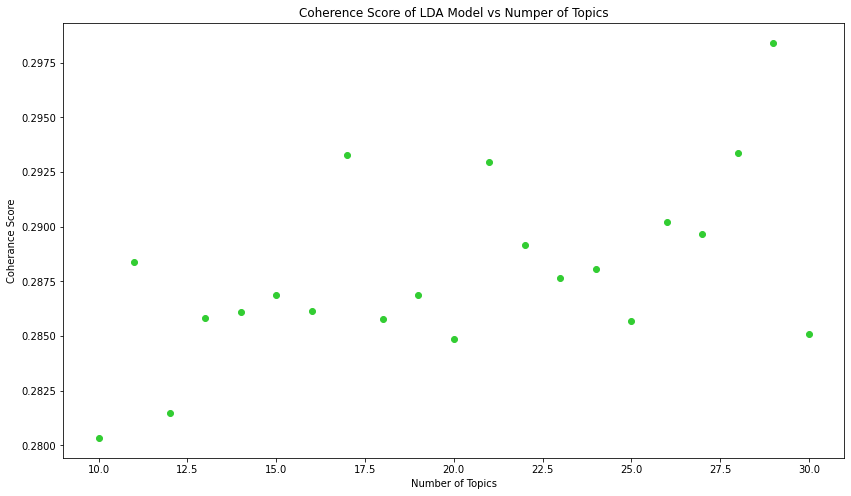

In [16]:
plt.figure(figsize = (14,8))
plt.scatter(x = np.arange(10,31), y = coherence_score_values, color = 'limegreen')
plt.xlabel('Number of Topics')
plt.ylabel('Coherance Score')
plt.title('Coherence Score of LDA Model vs Numper of Topics')
plt.show()

In [17]:
optimal_num_topics = coherence_score_values.index(max(coherence_score_values))
print(coherence_score_values.index(max(coherence_score_values)))

19


In [18]:
print(coherence_score_values[19])

0.29841624153200935


In [19]:
lda_optimzed = lda_gensim(num_topics = 19, 
                                corpus = corpus, 
                                id2word = dictionary)


#dump our model into pickle file
joblib.dump(lda, '/content/drive/MyDrive/gensim_lda_19.pkl')

['/content/drive/MyDrive/gensim_lda_19.pkl']

In [21]:
lda_viz_19_topics = pyLDAvis.gensim_models.prepare(topic_model = lda_optimzed,
                                            corpus = corpus,
                                            dictionary = dictionary)
pyLDAvis.save_html(lda_viz_19_topics, '/content/drive/MyDrive/gensim_lda+_viz_19.html')

In [22]:
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.006139 -0.011756       1        1  13.331056
6      0.023506 -0.009432       2        1  12.964511
16    -0.001221 -0.004757       3        1   6.548747
5      0.000767  0.002841       4        1   5.777018
19    -0.000426 -0.004345       5        1   5.090907
4     -0.011999 -0.008522       6        1   5.070791
7      0.014616  0.003938       7        1   4.990708
3     -0.011162 -0.006540       8        1   4.829516
14    -0.003786  0.006108       9        1   4.559884
0      0.005312  0.000086      10        1   4.298316
17     0.002984 -0.001870      11        1   4.295129
8     -0.012453 -0.008095      12        1   4.137462
15     0.043314  0.007289      13        1   3.791830
9     -0.003677  0.017886      14        1   3.776142
10    -0.006329  0.001100      15        1   3.588424
13    -0.019119  0.018656      16        1   3.151090
2     -0.003740 -0.000848      17        1   2.929218
12     0.000540  0.001144      18        1   2.784472
1      0.000662 -0.007261      19        1   2.330432
11    -0.011648  0.004376      20        1   1.754349, topic_info=        Term         Freq        Total Category  logprob  loglift
299     said  5567.000000  5567.000000  Default  30.0000  30.0000
1107  vaccin  2932.000000  2932.000000  Default  29.0000  29.0000
302      say  3078.000000  3078.000000  Default  28.0000  28.0000
395     year  2364.000000  2364.000000  Default  27.0000  27.0000
209     like  2087.000000  2087.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
766     mani    20.650924  1250.250875  Topic20  -6.2105  -0.0603
372      two    21.373783  1415.824579  Topic20  -6.1761  -0.1502
1299     day    21.189249  1863.460645  Topic20  -6.1848  -0.4336
722     home    19.636778  1172.255610  Topic20  -6.2609  -0.0462
240     need    19.149155  1218.644287  Topic20  -6.2860  -0.1102

[1626 rows x 6 columns], token_table=      Topic      Freq Term
term                      
594       1  0.120188  're
594       2  0.105620  're
594       3  0.049168  're
594       4  0.069199  're
594       5  0.043705  're
...     ...       ...  ...
397      16  0.047446  ’re
397      17  0.026764  ’re
397      18  0.026764  ’re
397      19  0.015815  ’re
397      20  0.013382  ’re

[6038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 7, 17, 6, 20, 5, 8, 4, 15, 1, 18, 9, 16, 10, 11, 14, 3, 13, 2, 12])

In [23]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [24]:
df_topic_sents_keywords = format_topics_sentences(lda_optimzed, 
                                                  corpus, 
                                                  text_data)

In [25]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#Adding our Original Source
df_dominant_topic['Source'] = df['Source']

In [26]:
df_dominant_topic.head(3)

Document_No  ...    Source
0            0  ...  Bridgemi
1            1  ...  Bridgemi
2            2  ...  Bridgemi

[3 rows x 6 columns]

In [27]:
df_dominant_topic.to_csv('/content/drive/MyDrive/labeled_data_gensim_LDA_19.csv')